# Automatic Tagging on Music Danceability Using Convolutional Neural Network

To run this notebook, please add this [file](https://drive.google.com/drive/folders/1y2am_lt2iuCbmEJuEOXLbpGyy7GWUBct?usp=sharing) to your google drive. It includes:


*   audio: chunk 5, 10, 13, 14, 16, 18, 19 of the MTG-Jamendo Dataset
*   annotation: manual annotation files corresponding to the audio chunk
*   model: model checkpoint for resuming training and inference, and other necessary modules
*   notation: labels, paths, and partition split information

To use a GPU:
**Runtime > Change runtime type**
and select **GPU** as **Hardware accelerator**

However, it still takes a long time to train the model for even one epoch (about 3h). You can skip the "training" part to see the result by running the "evaluation" part, which takes about 0.5h for test.


## Preparation

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install torchaudio

     |████████████████████████████████| 3.1MB 2.8MB/s 


In [0]:
import os
import sys
import time
import datetime
import numpy as np
import pickle
import json
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn
import torch
from torch import nn
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import Variable
import torchaudio

root_dir = '/content/drive/My Drive/MIR project'
audio_dir = '/content/drive/My Drive/MIR project/audio'
annotation_dir = '/content/drive/My Drive/MIR project/annotation'
model_dir = '/content/drive/My Drive/MIR project/model'
notation_dir = '/content/drive/My Drive/MIR project/notation'

### Notations
Create two dictionaries ```labels``` and ```audio_paths``` to store the "danceability" and path for each audio track. (It takes some time to run through all the files. For convenience, I save the these dictionaries in google drive and we can load them directly).

Data split: set chunk 5, 10, 13, 14, 16 as training set, chunk 19 as validation set, and chunk 18 as test set.


In [0]:
# labels = {}

# for root, dirs, files in os.walk(annotation_dir):
#   for file in files:
#     if file.startswith('miscellaneous'):
#       ID = file.split('_')[1][:-9]
#       with open(os.path.join(root, file)) as f:
#         annotation = json.load(f)
#       labels[ID] = annotation['danceability']

labels_file = os.path.join(notation_dir, 'labels.json')
# with open(labels_file, "w") as fp:
#   json.dump(labels, fp)

with open(labels_file) as f:
  labels = json.load(f)

In [0]:
# chunk_train = ['5','10','13','14','16']
# chunk_validation = ['19']
# chunk_test = ['18']
# audio_paths = {}
# partition = {
#     'train':[],
#     'validation':[],
#     'test':[]
# }

# for root, dirs, files in os.walk(audio_dir):
#   for file in files:
#     if file.endswith('.mp3'):
#       chunk_number = root.split('/')[-2]
#       ID = file.split('.')[0]

#       if ID in labels: # Omit those audio tracks that have no corresponding annotations, 
#         audio_paths[ID] = os.path.join(root, file)
        
#         if chunk_number in chunk_train:
#           partition['train'].append(ID)
#         elif chunk_number in chunk_validation:
#           partition['validation'].append(ID)
#         elif chunk_number in chunk_test:
#           partition['test'].append(ID)

partition_file = os.path.join(notation_dir, 'partition.json')
# with open(partition_file, "w") as fp1:
#   json.dump(partition, fp1)
with open(partition_file) as fp1:
  partition = json.load(fp1)

path_file = os.path.join(notation_dir, 'paths.json')
# with open(path_file, "w") as fp2:
#   json.dump(audio_paths, fp2)
with open(path_file) as fp2:
  audio_paths = json.load(fp2)

## Data loader

In [0]:
class Dataset(data.Dataset):
    def __init__(self, list_IDs, labels, paths): # partition[train/val/test], labels, audio_paths
        self.labels = labels
        self.list_IDs = list_IDs
        self.paths = paths

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index): # use torchaudio.load
        ID = self.list_IDs[index]
        si, ei = torchaudio.info(self.paths[ID])
        rate = int(si.rate) # read the sample rate
        waveform, sr = torchaudio.load(self.paths[ID], num_frames=rate*30, offset=0) # load the first 30s of each audio
        waveform = torchaudio.transforms.Resample(orig_freq = sr, new_freq=16000)(waveform) # resample
        waveform = torch.mean(waveform, 0) # downmix to mono
        labels = int(self.labels[ID])
        return waveform, labels

train_set = Dataset(partition['train'], labels, audio_paths)
validation_set = Dataset(partition['validation'], labels, audio_paths)
test_set = Dataset(partition['test'], labels, audio_paths)

print("Train set size: " + str(len(train_set)))
print("Validation set size: " + str(len(validation_set)))
print("Test set size: " + str(len(test_set)))

# Parameters
params = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 1,
          'drop_last': True}

train_loader = data.DataLoader(train_set, **params)
validation_loader = data.DataLoader(validation_set, **params)
test_loader = data.DataLoader(test_set, **params)

Train set size: 2705
Validation set size: 576
Test set size: 563


## Models

In [0]:
sys.path.insert(1, model_dir)

from modules import Conv_1d, ResSE_1d, Conv_2d, Res_2d, Conv_V, Conv_H, HarmonicSTFT, Res_2d_mp
from attention_modules import BertConfig, BertEncoder, BertEmbeddings, BertPooler, PositionalEncoding

### MusiCNN

In [0]:
class Musicnn(nn.Module):
    '''
    Pons et al. 2017
    End-to-end learning for music audio tagging at scale.
    This is the updated implementation of the original paper. Referred to the Musicnn code.
    https://github.com/jordipons/musicnn
    '''
    def __init__(self,
                sample_rate=16000,
                n_fft=512,
                f_min=0.0,
                f_max=8000.0,
                n_mels=96,
                n_class=50,
                dataset='mtat'):
        super(Musicnn, self).__init__()

        # Spectrogram
        self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                         n_fft=n_fft,
                                                         f_min=f_min,
                                                         f_max=f_max,
                                                         n_mels=n_mels)
        self.to_db = torchaudio.transforms.AmplitudeToDB()
        self.spec_bn = nn.BatchNorm2d(1)

        # Pons front-end
        m1 = Conv_V(1, 204, (int(0.7*96), 7))
        m2 = Conv_V(1, 204, (int(0.4*96), 7))
        m3 = Conv_H(1, 51, 129)
        m4 = Conv_H(1, 51, 65)
        m5 = Conv_H(1, 51, 33)
        self.layers = nn.ModuleList([m1, m2, m3, m4, m5])

        # Pons back-end
        backend_channel= 512 if dataset=='msd' else 64
        self.layer1 = Conv_1d(561, backend_channel, 7, 1, 1)
        self.layer2 = Conv_1d(backend_channel, backend_channel, 7, 1, 1)
        self.layer3 = Conv_1d(backend_channel, backend_channel, 7, 1, 1)

        # Dense
        dense_channel = 500 if dataset=='msd' else 200
        self.dense1 = nn.Linear((561+(backend_channel*3))*2, dense_channel)
        self.bn = nn.BatchNorm1d(dense_channel)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(dense_channel, n_class)

    def forward(self, x):
        # Spectrogram
        x = self.spec(x)
        x = self.to_db(x)
        x = x.unsqueeze(1)
        x = self.spec_bn(x)

        # Pons front-end
        out = []
        for layer in self.layers:
            out.append(layer(x))
        out = torch.cat(out, dim=1)

        # Pons back-end
        length = out.size(2)
        res1 = self.layer1(out)
        res2 = self.layer2(res1) + res1
        res3 = self.layer3(res2) + res2
        out = torch.cat([out, res1, res2, res3], 1)

        mp = nn.MaxPool1d(length)(out)
        avgp = nn.AvgPool1d(length)(out)

        out = torch.cat([mp, avgp], dim=1)
        out = out.squeeze(2)

        out = self.relu(self.bn(self.dense1(out)))
        out = self.dropout(out)
        out = self.dense2(out)
        out = nn.Sigmoid()(out)

        return out

## Training

In [0]:
model = Musicnn()
model = model.cuda() # to use GPUs
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
reconst_loss = nn.CrossEntropyLoss()

In [0]:
start_t = time.time()
num_epoch = 1
for epoch in range(num_epoch):
    # load checkpoint
    checkpoint = torch.load(os.path.join(model_dir, 'checkpoint.pt'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    model.train()

    ctr = 0
    for x, y in train_loader:
        ctr += 1
        # to GPU
        x = x.cuda()
        y = y.cuda()
        
        # predict
        prd = model(x)
        loss = reconst_loss(prd, y)
        
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print log
        if ctr % 15 == 0:
            print("[%s] Epoch [%d/%d] Iter [%d/%d] train loss: %.4f Elapsed: %s" %
                 (datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                 epoch+1, num_epoch, ctr, len(train_loader), loss.item(),
                 datetime.timedelta(seconds=time.time()-start_t)))
    
    # save checkpoint for resuming training
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
        }, os.path.join(model_dir, 'checkpoint.pt'))


    model.eval()
    ctr = 0
    prd_array = []
    gt_array = []
    for x, y in validation_loader:
        ctr += 1
        # to GPU
        x = x.cuda()
        y = y.cuda()
        
        # predict
        prd = model(x)
        loss = reconst_loss(prd, y)
        
        # append
        prd = prd.detach().cpu()
        y = y.detach().cpu()
        for _p in prd:
            prd_array.append(int(_p.argmax()))
        for _y in y:
            gt_array.append(int(_y))
        
        # print log
        if ctr % 7 == 0:
            print("[%s] Epoch [%d/%d] Iter [%d/%d] validation loss: %.4f Elapsed: %s" %
                 (datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                 epoch+1, num_epoch, ctr, len(validation_loader), loss.item(),
                 datetime.timedelta(seconds=time.time()-start_t)))
                             
    print("accuracy: %.4f" % sklearn.metrics.accuracy_score(gt_array, prd_array))

[2020-03-30 13:59:25] Epoch [1/1] Iter [15/338] train loss: 3.0001 Elapsed: 0:09:23.723955
[2020-03-30 14:08:42] Epoch [1/1] Iter [30/338] train loss: 2.9932 Elapsed: 0:18:40.679093
[2020-03-30 14:18:13] Epoch [1/1] Iter [45/338] train loss: 2.9914 Elapsed: 0:28:11.627579
[2020-03-30 14:27:30] Epoch [1/1] Iter [60/338] train loss: 3.0015 Elapsed: 0:37:28.469467
[2020-03-30 14:36:26] Epoch [1/1] Iter [75/338] train loss: 2.9959 Elapsed: 0:46:24.112053
[2020-03-30 14:45:21] Epoch [1/1] Iter [90/338] train loss: 3.0062 Elapsed: 0:55:19.627416
[2020-03-30 14:54:32] Epoch [1/1] Iter [105/338] train loss: 2.9913 Elapsed: 1:04:30.114479
[2020-03-30 15:03:48] Epoch [1/1] Iter [120/338] train loss: 2.9903 Elapsed: 1:13:46.852998
[2020-03-30 15:12:37] Epoch [1/1] Iter [135/338] train loss: 2.9934 Elapsed: 1:22:35.285098
[2020-03-30 15:21:40] Epoch [1/1] Iter [150/338] train loss: 2.9896 Elapsed: 1:31:37.892848
[2020-03-30 15:30:59] Epoch [1/1] Iter [165/338] train loss: 3.0085 Elapsed: 1:40:57.1

## Evaluation

In [0]:
# load model
checkpoint = torch.load(os.path.join(model_dir, 'checkpoint.pt'))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
prd_array = []
gt_array = []
for x, y in test_loader:
    # to GPU
    x = x.cuda()
    y = y.cuda()

    # predict
    prd = model(x)
    loss = reconst_loss(prd, y)

    # append
    prd = prd.detach().cpu()
    y = y.detach().cpu()
    for _p in prd:
        prd_array.append(int(_p.argmax()))
    for _y in y:
        gt_array.append(int(_y))

print("accuracy: %.4f" % sklearn.metrics.accuracy_score(gt_array, prd_array)) 
# plt.figure()
# cm = sklearn.metrics.confusion_matrix(gt_array, prd_array)
# danceability = ['not_danceable', 'danceable']
# seaborn.heatmap(cm, annot=True, xticklabels=danceability, yticklabels=danceability)

accuracy: 0.7571


Text(0.5, 1.0, 'danceability_self-trained-MusiCNN')

<Figure size 432x288 with 0 Axes>

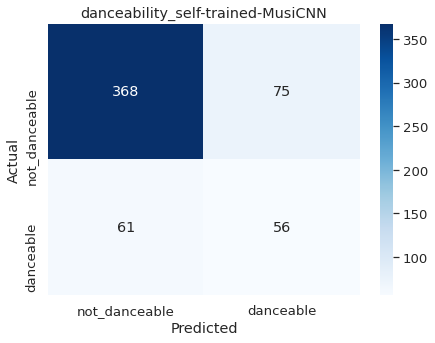

In [0]:
danceability = ['not_danceable', 'danceable']
plt.figure()
conf_mat = pd.DataFrame(sklearn.metrics.confusion_matrix(gt_array, prd_array), columns = danceability, index = danceability)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
seaborn.set(font_scale = 1.2)
ax = plt.axes()
cm = seaborn.heatmap(conf_mat, cmap = "Blues", annot = True, fmt = 'd', ax = ax)
ax.set_title('danceability'+'_self-trained-MusiCNN')
save_cm = cm.get_figure()
save_cm.savefig(task_name+'self-trained-MusiCNN.png')